In [1]:
import pandas as pd


In [5]:
df = pd.read_csv("./train.csv")

df.columns


Index(['Number words female', 'Total words', 'Number of words lead',
       'Difference in words lead and co-lead', 'Number of male actors', 'Year',
       'Number of female actors', 'Number words male', 'Gross',
       'Mean Age Male', 'Mean Age Female', 'Age Lead', 'Age Co-Lead', 'Lead'],
      dtype='object')

## Data Analysis

### Mean Gross by Lead

Text(0, 0.5, 'Gross')

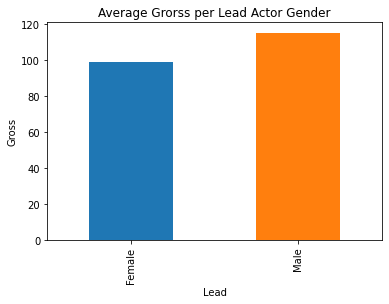

In [25]:

ax = df.groupby('Lead').Gross.mean().plot(kind='bar',color=['C0','C1'], title='Average Grorss per Lead Actor Gender')
ax.set_ylabel("Gross")

### Leads gender per Year

Text(0, 0.5, 'Number of movies')

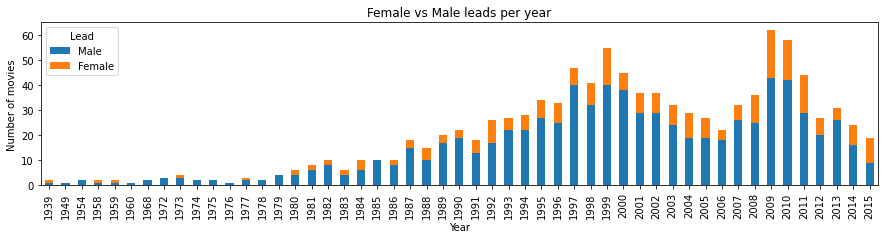

In [51]:
a = df[['Lead','Year']].groupby(['Year', 'Lead']).size().sort_index().unstack().fillna(0)
a = a[['Male','Female']]
ax = a.plot(kind='bar', stacked=True, title="Female vs Male leads per year", figsize=(15,3))
ax.set_ylabel("Number of movies")

In [39]:
import joblib
import json
def save_best_estimator(clf, name):
  best_model_stats = {}
  for key, val in clf.cv_results_.items():
    real_val = val[clf.best_index_]
    if 'numpy' in str(type(real_val)):
      if 'float' in str(type(real_val)):
        best_model_stats[key] = float(real_val) 
      else:
        best_model_stats[key] = int(real_val) 
    else:
      best_model_stats[key] = real_val
  joblib.dump(clf.best_estimator_, f'{name}.pkl', compress = 1)
  with open(f"{name}_stats.json", 'w') as jf:
    json.dump(best_model_stats, jf, indent=4)

# Training

In [6]:
x = df.drop(columns="Lead")
x.info

<bound method DataFrame.info of       Number words female  Total words  Number of words lead  \
0                    1512         6394                2251.0   
1                    1524         8780                2020.0   
2                     155         4176                 942.0   
3                    1073         9855                3440.0   
4                    1317         7688                3835.0   
...                   ...          ...                   ...   
1034                  303         2398                1334.0   
1035                  632         8404                1952.0   
1036                 1326         2750                 877.0   
1037                  462         3994                 775.0   
1038                 2735        11946                3410.0   

      Difference in words lead and co-lead  Number of male actors  Year  \
0                                      343                      2  1995   
1                                     1219       

In [7]:
y = df['Lead'].replace({"Male": 1, "Female": -1})
y

0      -1
1       1
2       1
3       1
4       1
       ..
1034    1
1035   -1
1036    1
1037   -1
1038    1
Name: Lead, Length: 1039, dtype: int64

## Decision Tree




In [40]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

parameters = {'model__max_depth':range(3,20), 'model__min_samples_split': range(2,15)}
model = Pipeline([('scaler', StandardScaler()), ('model', tree.DecisionTreeClassifier())])

clf = GridSearchCV(model, parameters, n_jobs=4, cv=5)
clf.fit(X=x, y=y)
tree_model = clf.best_estimator_
save_best_estimator(clf, "decisionTree")
print (clf.best_score_, clf.best_params_) 

## 0.8065356744704572 {'model__max_depth': 7, 'model__min_samples_split': 3}


0.8065356744704572 {'model__max_depth': 7, 'model__min_samples_split': 3}


## Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
parameters = {'model__n_estimators':range(10,150, 10),'model__bootstrap': [True, False], 'model__min_samples_split': range(2,15)}

model = Pipeline([('scaler', StandardScaler()), ('model', RandomForestClassifier())])

clf = GridSearchCV(model, parameters, n_jobs=4, cv=5)
clf.fit(X=x, y=y)
randomforest_model = clf.best_estimator_
save_best_estimator(clf, "randomForest")
print (clf.best_score_, clf.best_params_)

## 0.8536696395392047 {'model__bootstrap': False, 'model__min_samples_split': 4, 'model__n_estimators': 130}

0.8536696395392047 {'model__bootstrap': False, 'model__min_samples_split': 4, 'model__n_estimators': 130}


## Bagging

In [43]:
from sklearn.ensemble import BaggingClassifier
parameters = {'model__n_estimators':range(5,150,5),'model__bootstrap': [True, False], 'model__bootstrap_features': [True, False]}
model = Pipeline([('scaler', StandardScaler()), ('model', BaggingClassifier())])

clf = GridSearchCV(model, parameters, n_jobs=4, cv=5)
clf.fit(X=x, y=y)
save_best_estimator(clf, "bagging")
print (clf.best_score_, clf.best_params_)

# 0.8613851727982164 {'model__bootstrap': True, 'model__bootstrap_features': False, 'model__n_estimators': 105}

0.8613851727982164 {'model__bootstrap': True, 'model__bootstrap_features': False, 'model__n_estimators': 105}
